In [6]:
# import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 



import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)])



df_ratings = spark.read.csv('data/u.data',sep='\t', header=False, schema=schema)

In [9]:
df_ratings.show()

+----+-----+------+---------+
|user|movie|rating|timestamp|
+----+-----+------+---------+
| 196|  242|     3|881250949|
| 186|  302|     3|891717742|
|  22|  377|     1|878887116|
| 244|   51|     2|880606923|
| 166|  346|     1|886397596|
| 298|  474|     4|884182806|
| 115|  265|     2|881171488|
| 253|  465|     5|891628467|
| 305|  451|     3|886324817|
|   6|   86|     3|883603013|
|  62|  257|     2|879372434|
| 286| 1014|     5|879781125|
| 200|  222|     5|876042340|
| 210|   40|     3|891035994|
| 224|   29|     3|888104457|
| 303|  785|     3|879485318|
| 122|  387|     5|879270459|
| 194|  274|     2|879539794|
| 291| 1042|     4|874834944|
| 234| 1184|     2|892079237|
+----+-----+------+---------+
only showing top 20 rows



### Get some statistics about the data

In [10]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 943
Number of unique movies: 1682
Number of rating: 100000


In [11]:
# The density of the matrix is 
100000/(943*1682)

0.06304669364224531

### Split the data
We can split the data like this as it is not in a utility matrix so this is a good way to sample the data.  There is an option of splitting by time as well.

In [12]:
train, test = df_ratings.randomSplit([0.8, 0.2], seed=427471138)

In [13]:
train.count(), test.count()

(79998, 20002)

### Looking at the breakdown of the split

Max Ratings: 593
Min Ratings: 10


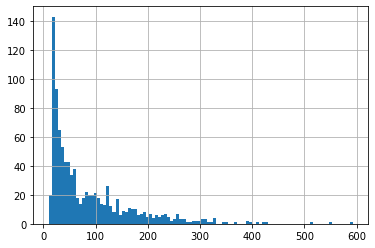

In [14]:
user_count = train.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 453
Min Ratings: 1


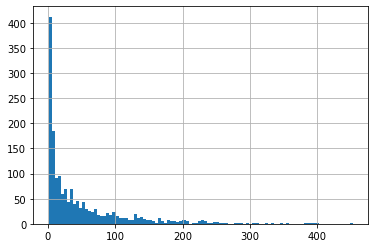

In [15]:
movie_count = train.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

Max Ratings: 144
Min Ratings: 1


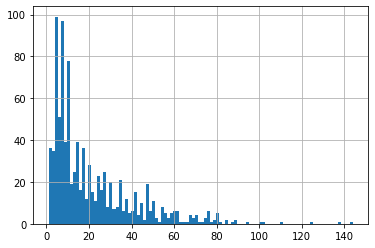

In [16]:
user_count = test.groupBy('user').count().toPandas()

print('Max Ratings: {}'.format(user_count['count'].max()))
print('Min Ratings: {}'.format(user_count['count'].min()))
user_count['count'].hist(bins = 100)

Max Ratings: 130
Min Ratings: 1


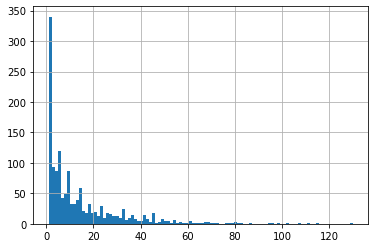

In [17]:
movie_count = test.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

### Training the explicit model model

In [18]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender = als_model.fit(train)

### Create a record of user 1 and movie 100 to get predictions from 

In [19]:
data = [(1, 100)]
columns = ('user', 'movie')
one_row_spark_df = spark.createDataFrame(data, columns)

In [20]:
# Check that it worked
one_row_spark_df.show()

+----+-----+
|user|movie|
+----+-----+
|   1|  100|
+----+-----+



In [21]:
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [22]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [23]:
np.dot(user_factors, item_factors)

4.3858877122416144

In [24]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+----+-----+----------+
|user|movie|prediction|
+----+-----+----------+
|   1|  100| 4.3858876|
+----+-----+----------+



You can see we get the same prediction from the dot product of the vectors

In [25]:
# Get the top movies for a user 1

recommender.recommendForUserSubset(one_row_spark_df, 10).show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|   1|[[408, 5.0479074]...|
+----+--------------------+



In [26]:
predictions = recommender.transform(test)

In [27]:
predictions.describe().show()

+-------+-----------------+------------------+------------------+-------------------+----------+
|summary|             user|             movie|            rating|          timestamp|prediction|
+-------+-----------------+------------------+------------------+-------------------+----------+
|  count|            20002|             20002|             20002|              20002|     20002|
|   mean|463.5897410258974| 420.1968303169683|3.5422957704229576|8.835040387062794E8|       NaN|
| stddev|266.5949396137361|329.31280867535975|1.1275958120245677|  5338320.602518857|       NaN|
|    min|                1|                 1|                 1|          874724710|0.36500934|
|    max|              943|              1681|                 5|          893286637|       NaN|
+-------+-----------------+------------------+------------------+-------------------+----------+



Given the the stats it looks like our data does contin missing values.

## Part 2 Implicit

We will add an implicit rating to the dataframe and then use that for predictions

In [28]:
# add the implicit rating column

train = train.withColumn("imp_rating", lit(1))
train.show(5)

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|imp_rating|
+----+-----+------+---------+----------+
|   1|    2|     3|876893171|         1|
|   1|    3|     4|878542960|         1|
|   1|    4|     3|876893119|         1|
|   1|    7|     4|875071561|         1|
|   1|    9|     5|878543541|         1|
+----+-----+------+---------+----------+
only showing top 5 rows



In [29]:
als_model_imp = ALS(userCol='user',
                itemCol='movie',
                ratingCol='imp_rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [30]:
# Looking at the recommendations for user 1 to compare to what the explicit gave back 
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

[Row(user=1, recommendations=[Row(movie=174, rating=0.9075787663459778), Row(movie=50, rating=0.8714457154273987), Row(movie=168, rating=0.8463552594184875), Row(movie=204, rating=0.8344299793243408), Row(movie=172, rating=0.831427276134491), Row(movie=173, rating=0.8206742405891418), Row(movie=56, rating=0.8173366189002991), Row(movie=181, rating=0.8032495975494385), Row(movie=195, rating=0.7934309244155884), Row(movie=96, rating=0.792775571346283)])]

### Implicit recommendation with interactions

In [31]:
als_model_imp = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                implicitPrefs=True,
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

recommender_imp = als_model_imp.fit(train)

In [32]:
recommender_imp.recommendForUserSubset(one_row_spark_df, 10).collect()

[Row(user=1, recommendations=[Row(movie=50, rating=1.0412098169326782), Row(movie=100, rating=1.0191421508789062), Row(movie=168, rating=0.9893996119499207), Row(movie=181, rating=0.9846006631851196), Row(movie=42, rating=0.9638375639915466), Row(movie=154, rating=0.9570358395576477), Row(movie=173, rating=0.9538309574127197), Row(movie=7, rating=0.9482871294021606), Row(movie=433, rating=0.9417609572410583), Row(movie=174, rating=0.9413334131240845)])]

## Part 3 Looking at explicit evaluation

In [33]:

# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [34]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [35]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [36]:
predictions_df.head()

,user,movie,rating,timestamp,prediction,squared_error
0,580,148,4,884125773,3.314450,0.469978
1,406,148,3,879540276,2.729056,0.073411
2,26,148,3,891377540,2.532030,0.218996
3,27,148,3,891543129,2.766154,0.054684
4,222,148,2,881061164,3.065005,1.134235


In [37]:
predictions_df.describe()

,user,movie,rating,timestamp,prediction,squared_error
count,20002.000000,20002.000000,20002.000000,2.000200e+04,20002.000000,2.000200e+04
mean,463.589741,420.196830,3.542296,8.835040e+08,3.398813,8.377901e-01
std,266.594940,329.312809,1.127596,5.338321e+06,0.684438,1.216645e+00
min,1.000000,1.000000,1.000000,8.747247e+08,0.365009,2.273737e-09
25%,254.000000,173.000000,3.000000,8.794519e+08,2.985260,8.447573e-02
50%,450.000000,318.000000,4.000000,8.828177e+08,3.462207,3.790039e-01
75%,682.000000,619.000000,4.000000,8.882061e+08,3.878964,1.089588e+00
max,943.000000,1681.000000,5.000000,8.932866e+08,5.522457,1.362189e+01


In [38]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.915308716923556

In [39]:
predictions_df.head()

,user,movie,rating,timestamp,prediction,squared_error
0,580,148,4,884125773,3.314450,0.469978
1,406,148,3,879540276,2.729056,0.073411
2,26,148,3,891377540,2.532030,0.218996
3,27,148,3,891543129,2.766154,0.054684
4,222,148,2,881061164,3.065005,1.134235


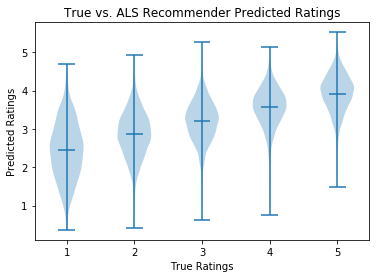

In [40]:

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()

### EXTRA CREDIT 

In [41]:
def rank_score(df):
    df2 = df.copy()
    df2['rank'] = df2.groupby("user")["prediction"].rank("dense", ascending=False, na_option='top') -1
    df2 = df2.join(df2.groupby("user")["rank"].max(), on='user', rsuffix='_max')
    df2['pct_rank'] = df2['rank']/df2['rank_max']
    
    return np.sum(df2['interactions']*df2['pct_rank'])/np.sum(df2['interactions'])
    

## Predictions from the implicit with impressions 

In [42]:
implicit_predictions = recommender_imp.transform(test)

In [43]:
implicit_predictions_df = implicit_predictions.toPandas()

In [44]:
implicit_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 5 columns):
user          20002 non-null int32
movie         20002 non-null int32
rating        20002 non-null int32
timestamp     20002 non-null int32
prediction    19973 non-null float32
dtypes: float32(1), int32(4)
memory usage: 390.8 KB


We will have to fill the missing valuse.  We will just 0

In [45]:
implicit_predictions_df = implicit_predictions_df.fillna(0)

In [49]:
# Rename the columns as we wanted Interactions not rating
implicit_predictions_df.columns = ['user','movie','interactions','timestamp','prediction']

In [50]:
implicit_predictions_df.head()

,user,movie,interactions,timestamp,prediction
0,580,148,4,884125773,0.422569
1,406,148,3,879540276,0.450218
2,26,148,3,891377540,0.545537
3,27,148,3,891543129,0.233229
4,222,148,2,881061164,0.688946


In [51]:
rank_score(implicit_predictions_df)

0.4763111957574119